In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: /workspace/iscat


In [41]:
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset
import random

class iScatDataset2(Dataset):
    def __init__(self, hdf5_path, classes=[0, 1, 2], apply_augmentation=False, normalize="minmax"):
        """
        PyTorch Dataset for microscopy data stored in an HDF5 file.
        
        Args:
            hdf5_path (str): Path to the HDF5 file.
            classes (list): Classes to include in the mask.
            apply_augmentation (bool): Whether to apply random flips.
            normalize (str): Normalization method, either 'minmax' or 'zscore'.
        """
        self.hdf5_path = hdf5_path
        self.classes = classes
        self.apply_augmentation = apply_augmentation
        self.normalize = normalize
        
        # Open HDF5 file and get dataset sizes
        with h5py.File(hdf5_path, "r") as f:
            self.image_dataset_size = f["image_patches"].shape[0]
            self.num_slices = f["image_patches"].shape[1]

    def __len__(self):
        return self.image_dataset_size

    def __getitem__(self, idx):
        # Load the data from HDF5
        with h5py.File(self.hdf5_path, "r") as f:
            image = f["image_patches"][idx].copy()  # Shape: (Z, H, W)
            masks = f["mask_patches"][idx].copy()   # Shape: (C, H, W)

        # Convert to float32
        image = image.astype(np.float32)
        
        # Normalize the image
        if self.normalize == "minmax":
            image -= image.min()
            image /= (image.max() + 1e-8)
        elif self.normalize == "zscore":
            mean = image.mean()
            std = image.std() + 1e-8
            image = (image - mean) / std
        else:
            raise ValueError("Invalid normalization method. Choose 'minmax' or 'zscore'.")

        # Process masks based on selected classes
        if len(self.classes) == 1:
            # Single-class mask
            mask = masks[self.classes[0]]
        else:
            # Multi-class mask
            mask = np.zeros_like(masks[0], dtype=np.uint8)
            for i, cls in enumerate(self.classes, start=1):
                mask[masks[cls] > 0] = i  # Assign class indices

        # Apply augmentation (random horizontal/vertical flips)
        if self.apply_augmentation:
            # Create new arrays after flipping to ensure contiguous memory
            if random.random() > 0.5:
                image = np.ascontiguousarray(np.flip(image, axis=-1))  # Horizontal flip
                mask = np.ascontiguousarray(np.flip(mask, axis=-1))
            if random.random() > 0.5:
                image = np.ascontiguousarray(np.flip(image, axis=-2))  # Vertical flip
                mask = np.ascontiguousarray(np.flip(mask, axis=-2))

        # Convert to PyTorch tensors
        image = torch.from_numpy(image)  # Shape: (Z, H, W)
        mask = torch.from_numpy(mask)    # Shape: (H, W)

        return image, mask

In [49]:
dataset = MicroscopyDataset('dataset/brightfield.hdf5',apply_augmentation=False,normalize="zscore")

In [53]:
dataset[0][1].shape

torch.Size([256, 256])

In [99]:
from src.models.Unet import UNet
DEVICE='cuda:11'
def load_model(path, num_classes=3,device=DEVICE):
    model = UNet(in_channels=201, num_classes=num_classes, init_features=64)
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  
    return model
model = load_model("experiments/runs/UNet_Brightfield_2025-01-19_11-39-10/best_model.pth")

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [100]:
from src.data_processing.dataset import iScatDataset2 
from sklearn.model_selection import train_test_split
hdf5_path = os.path.join('dataset', 'brightfield.hdf5')
with h5py.File(hdf5_path, "r") as f:
    num_samples = f["image_patches"].shape[0]
    
indices = np.arange(num_samples)
train_indices, valid_indices = train_test_split(indices, test_size=0.2, random_state=42)

valid_dataset = iScatDataset2(
    hdf5_path=hdf5_path,
    indices=valid_indices,
    classes=[0,1],
    apply_augmentation=False,  # No augmentation for validation
    normalize="zscore",
)

In [122]:
len(valid_dataset)

176

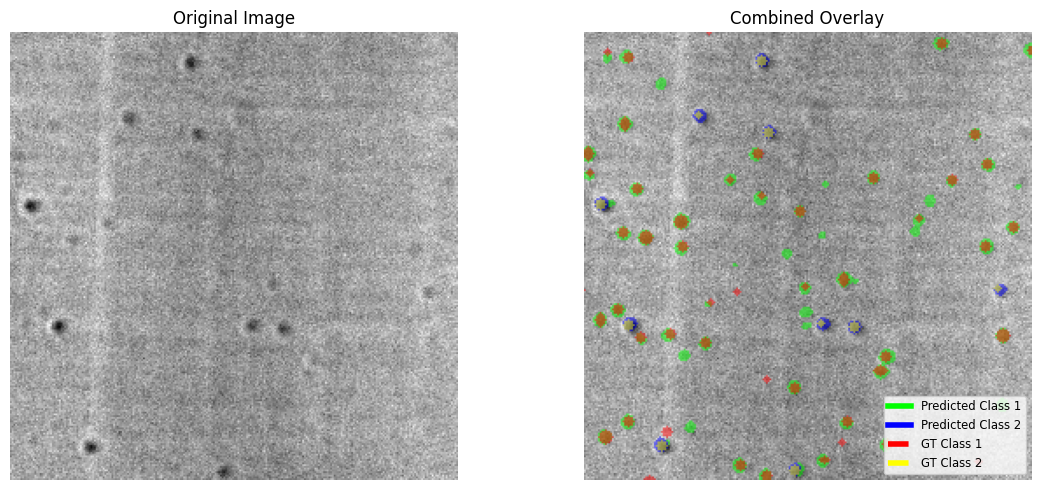

In [130]:
model.eval()
sample = valid_dataset[110]
with torch.no_grad():
    image = sample[0]
    ground_truth_mask= sample[1]
    predicted_mask = model(image.unsqueeze(0).to(DEVICE))
    predicted_mask = torch.argmax(predicted_mask.squeeze(0), dim=0).cpu().numpy()
    ground_truth_mask = ground_truth_mask.cpu().numpy()
    image = image.cpu().numpy()
from src.visualization import plot_image_with_masks
plot_image_with_masks(image[0], predicted_mask, ground_truth_mask, output_path="image_with_overlay.png")